![esi-logo](esi-logo.png)

# LAB 02 : OPTIMIZING AND TRAINING DEEP NEUTRAL NETWORKS WITH KERAS

Presented By: [Senhadji M Said]([http://](https://github.com/SenhadjiMSaid))

This report summarizes the experiments and findings from Lab 02 of the Deep Learning course, covering both Part 1 and Part 2. The lab notebooks can be accessed through the following links:
- [Part 1](https://www.kaggle.com/code/senhadjimohamedsaid/training-an-mlp-keras-on-mnist-dataset)
- [Part 2](https://www.kaggle.com/code/senhadjimohamedsaid/training-an-mlp-keras-on-mnist-dataset-part-2)

In [41]:
from IPython.core.display import display, HTML
display(HTML("<style> body { font-family: 'Cambria Math', serif; } </style>"))

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [43]:
import warnings
warnings.filterwarnings("ignore")

Useful functions

In [44]:
def plot_learning_graph_in_same_axis(histories_df,metric,split):
    models = histories_df["model"].value_counts().index
    ax = None
    for model in models:
        mask = histories_df["model"] == model
        metric_name = metric if split == "train" else "val_"+metric
        y = histories_df[metric_name][mask]
        x = list(range(y.shape[0]))
        ax = sns.lineplot(x=x,y=y,ax=ax,label=model)
    plt.legend()

In [45]:
def plot_overfitting_graphs(histories_df):

    models = histories_df["model"].value_counts().index

    for model in models:
        
        fig,(ax1, ax2) = plt.subplots(nrows=2)

        df = histories_df[histories_df["model"] == model]

        x = list(range(len(df)))

        sns.lineplot(x=x,y=df["loss"],ax=ax1)
        sns.lineplot(x=x,y=df["val_loss"],ax=ax1)

        ax1.set_title(f"Loss graph Train Vs Validation set for model : {model}")

        sns.lineplot(x=x,y=df["sparse_categorical_accuracy"],ax=ax2)
        sns.lineplot(x=x,y=df["val_sparse_categorical_accuracy"],ax=ax2)

        ax2.set_title(f"accuracy graph Train Vs Validation set for model : {model}")

        plt.tight_layout()
        plt.show()

# 1 Introduction
Deep Neural Networks (DNNs) are powerful machine learning models inspired by the human brain. They consist of multiple layers of interconnected neurons that learn hierarchical patterns from data. DNNs are widely used in various applications such as image classification, speech recognition, and natural language processing due to their ability to model complex relationships.
In this lab, we focus on optimizing and training deep neural networks using Keras. We will design, implement, and train a Multi-Layer Perceptron (MLP) model on the MNIST dataset. Different optimization strategies, including batch gradient descent, mini-batch gradient descent, and stochastic gradient descent, will be explored to improve model performance. Additionally, we will evaluate the training process using various metrics and visualize learning curves to analyze convergence and accuracy.


# 2 PART ONE: TRAINING AN MLP WITH KERAS


In [46]:
figures = {}

In [47]:
histories_df = pd.read_csv(os.path.join("output-partone","histories_df.csv"))
evaluation_df = pd.read_csv(os.path.join("output-partone","evaluation.csv"))
durations_df = pd.read_csv(os.path.join("output-partone","durations.csv"))

## 2.1 DISCUSSING THE TRAINING TIME OF THE MODELS


In [48]:
durations_df.columns = ["model","duration"]

In [49]:
durations_df

,model,duration
0,Batch Gradient Descent,9.876573
1,Mini Batch Gradient Descent,46.493688
2,Stochastic Gradient Descent,2666.381087
3,Mini Batch GD With Learning rate decay,47.432773
4,Mini Batch GD With Learning rate decay and mom...,48.782537
5,Adam,50.858643
6,RMSProp,48.649632


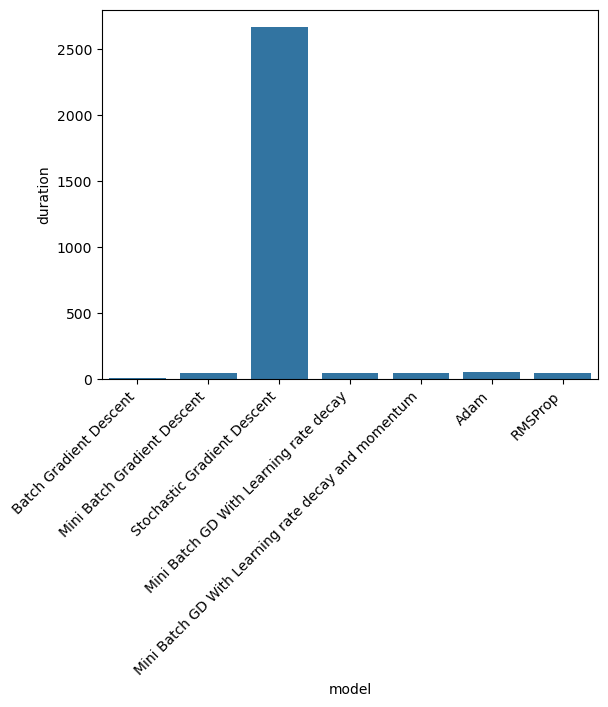

In [50]:
ax = sns.barplot(x=durations_df["model"],y=durations_df["duration"])
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')

<u>Figure 1</u> presents a histogram comparing the training times of different optimization strategies used in training the MLP model. **Stochastic Gradient Descent (SGD)** exhibits a significantly higher training time compared to other methods. This is because SGD updates model weights after each sample, leading to a high number of iterations and increased computational cost. <br> <br>
In contrast, **Mini-Batch Gradient Descent** and **Batch Gradient Descent** show significantly lower training times. **Mini-Batch Gradient Descent** strikes a balance between computational efficiency and model convergence speed by updating weights in small batches rather than after each individual sample. <br><br>
Furthermore, adaptive optimization algorithms like **Adam** and **RMSProp** demonstrate relatively short training durations. These methods dynamically adjust learning rates based on gradient information, allowing faster convergence and more efficient updates. The results suggest that while traditional gradient descent methods can be computationally expensive, modern adaptive optimizers provide a more efficient alternative for training deep neural networks. <br><br>
Overall, selecting an appropriate optimization strategy is crucial for balancing training time and model performance, especially when dealing with large datasets and deep architectures.

## 2.1 DISCUSSING THE PERFORMANCES OF THE DIFFERENT MODELS

In [51]:
evaluation_df.index = durations_df["model"]
evaluation_df

,loss,accuracy
model,,
Batch Gradient Descent,1.768822,0.580208
Mini Batch Gradient Descent,0.109087,0.968750
Stochastic Gradient Descent,0.176997,0.979688
Mini Batch GD With Learning rate decay,0.109371,0.966667
Mini Batch GD With Learning rate decay and momentum,0.101869,0.977813
Adam,0.172621,0.976875
RMSProp,0.174716,0.977708


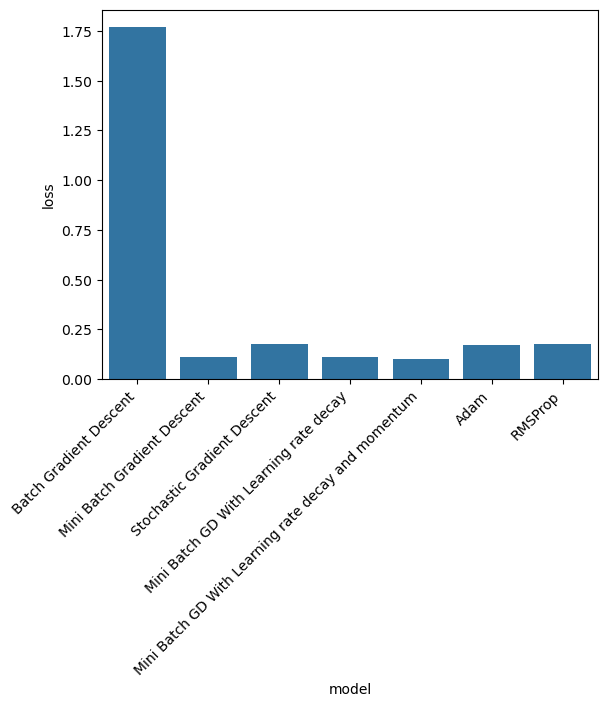

In [52]:
ax = sns.barplot(x=evaluation_df.index,y=evaluation_df["loss"])
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')

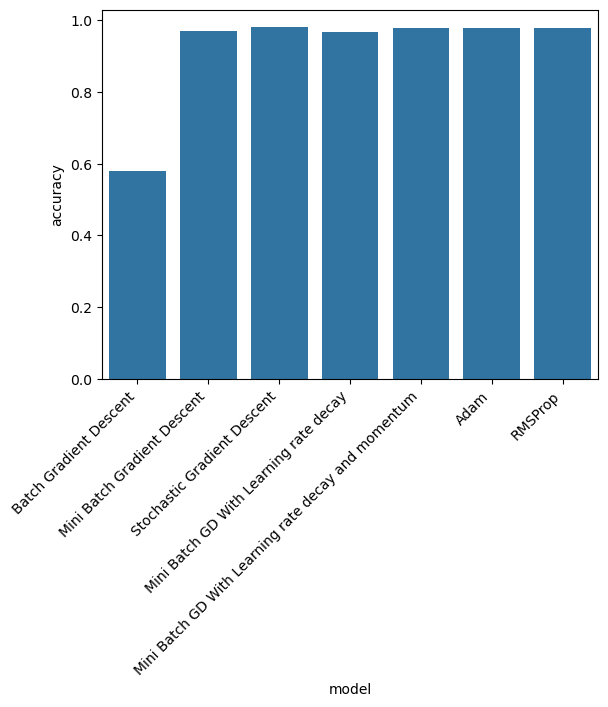

In [53]:
ax = sns.barplot(x=evaluation_df.index,y=evaluation_df["accuracy"])
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')

We notice overall that the Batch Gradient descent model performs the worst because it only performed less number of iterations,since the batch gradient descent processes the entire training set at once then $ \text{num}_\text{iterations} = \text{num}_\text{epochs} $ ,mean
while a Mini Batch Gradient descent with batch size equals to 32 and training set that contains 48,000 data points for
example performs $ \text{num}_\text{iterations} = \text{num}_\text{epochs} \times (\text{training\_set\_size} / \text{batch\_size}) = 50 \times (48000 / 32) = 75000 \text{  iterations} $. <br> <br>
This doesn’t mean we always have to go for smaller batches as it slows the training and introduces more noise which
explains why the Stochastic Gradient Descent had relatively higher loss (ignoring the Batch Gradient Descent).


## 2.3 COMPARING THE LEARNING GRAPHS FOR THE DIFFERENT MODELS

In [54]:
histories_df.head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,model
0,2.057138,0.350833,2.048862,0.354792,Batch Gradient Descent
1,2.051593,0.356536,2.043231,0.361979,Batch Gradient Descent
2,2.046053,0.361693,2.037604,0.367396,Batch Gradient Descent
3,2.040514,0.367214,2.031979,0.374375,Batch Gradient Descent
4,2.034973,0.373464,2.026354,0.381875,Batch Gradient Descent


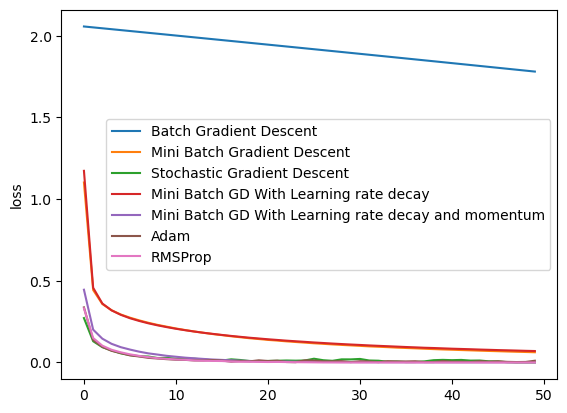

In [55]:
plot_learning_graph_in_same_axis(histories_df, "loss", "train")

(0.0, 50.0, 0.0, 1.2)

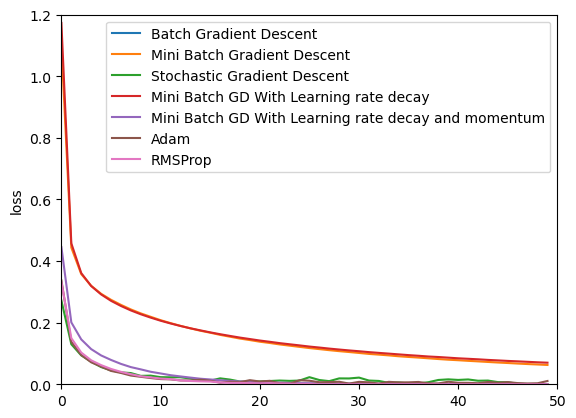

In [56]:
plot_learning_graph_in_same_axis(histories_df, "loss", "train")
plt.axis((0,50,0,1.2))

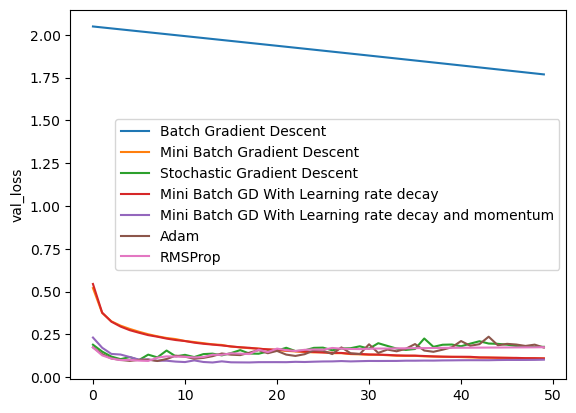

In [57]:
plot_learning_graph_in_same_axis(histories_df, "loss", "val")

(0.0, 50.0, 0.0, 0.5)

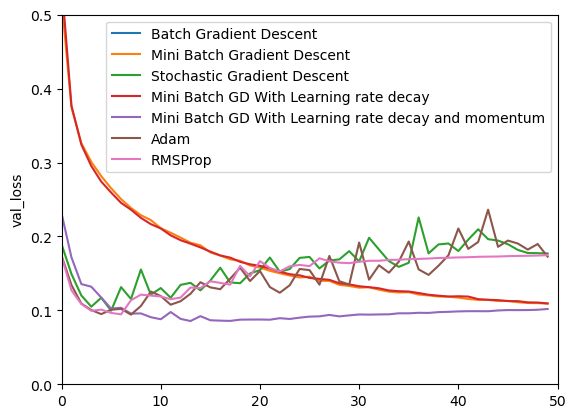

In [58]:
plot_learning_graph_in_same_axis(histories_df, "loss", "val")
plt.axis((0,50,0,0.5))

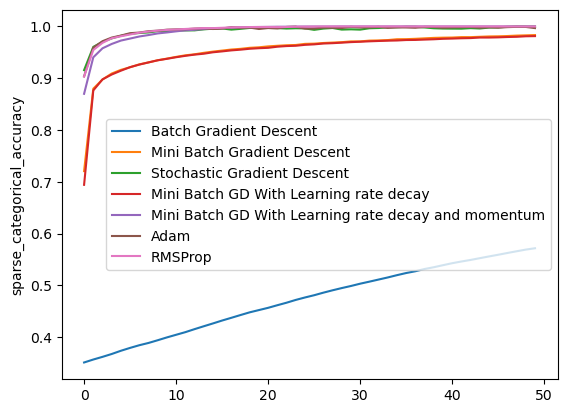

In [59]:
plot_learning_graph_in_same_axis(histories_df, "sparse_categorical_accuracy", "train")

(0.0, 50.0, 0.75, 1.0)

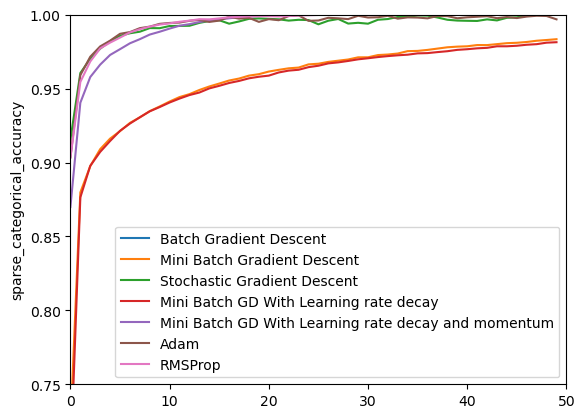

In [60]:
plot_learning_graph_in_same_axis(histories_df, "sparse_categorical_accuracy", "train")
plt.axis((0,50,0.75,1))

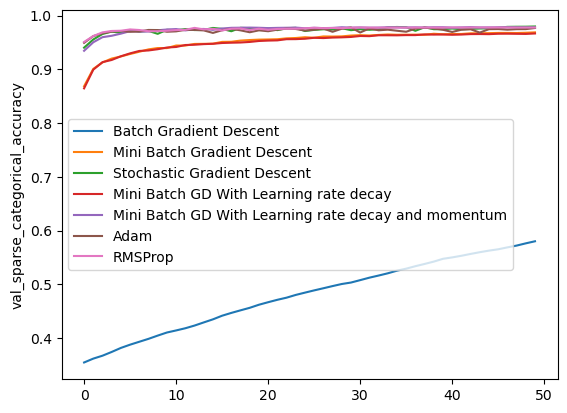

In [61]:
plot_learning_graph_in_same_axis(histories_df, "sparse_categorical_accuracy", "val")

(0.0, 50.0, 0.85, 1.0)

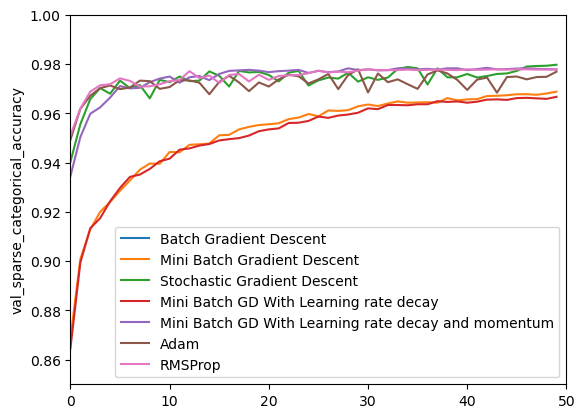

In [62]:
plot_learning_graph_in_same_axis(histories_df, "sparse_categorical_accuracy", "val")
plt.axis((0,50,0.85,1))

We notice that **Adam**,**RMSProp** and **Mini Batch Gradient Descent with momentum** converges faster than Mini Batch Gradient Descent,because they combine the current gradient with the previous gradients to overcome oscillations and noisy gradients thus preventing taking large steps in the wrong direction. <br> <br>
We also notice that **Adam**,**RMSProp** loss starts becoming less stable towards the last epochs due to the fact that the gradients becomes smaller at that point which can introduce instability a potential solution maybe reducing the learning rate.



## 2.4 THE CONVERGENCE GRAPHS FOR EACH MODEL

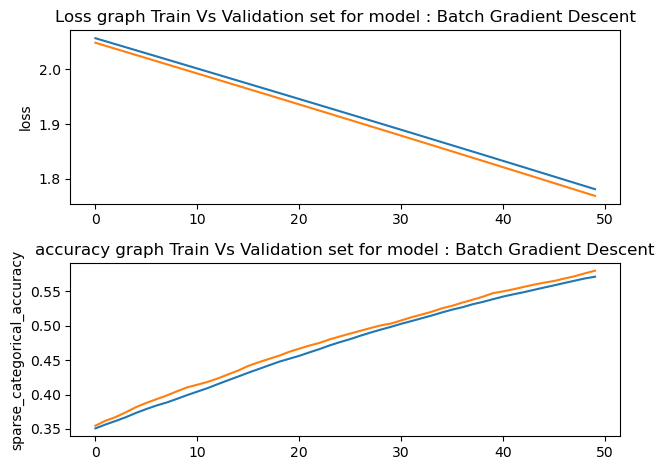

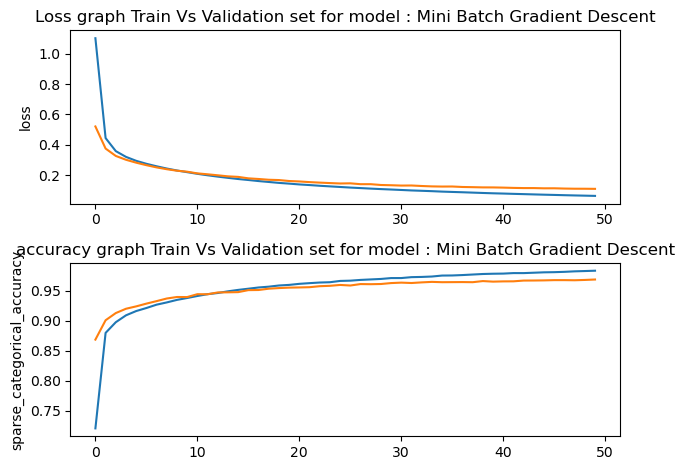

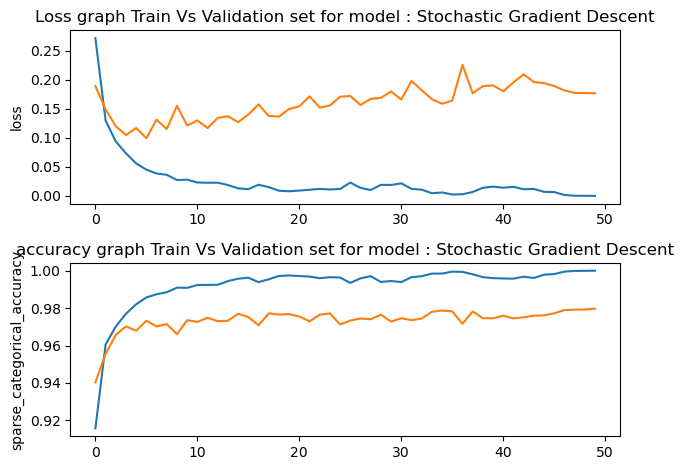

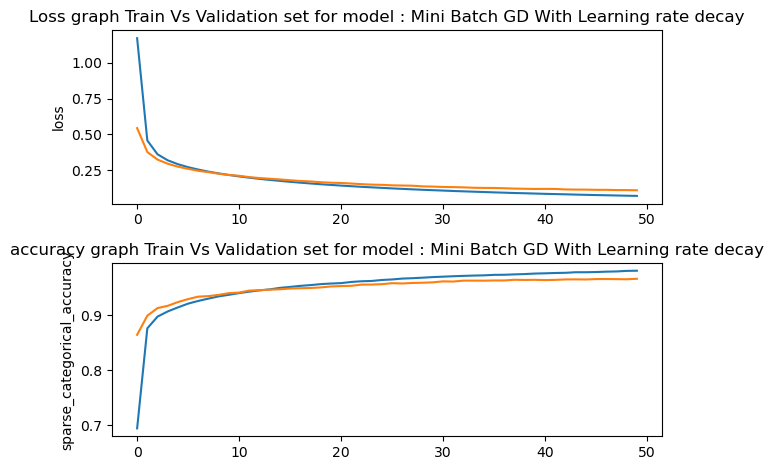

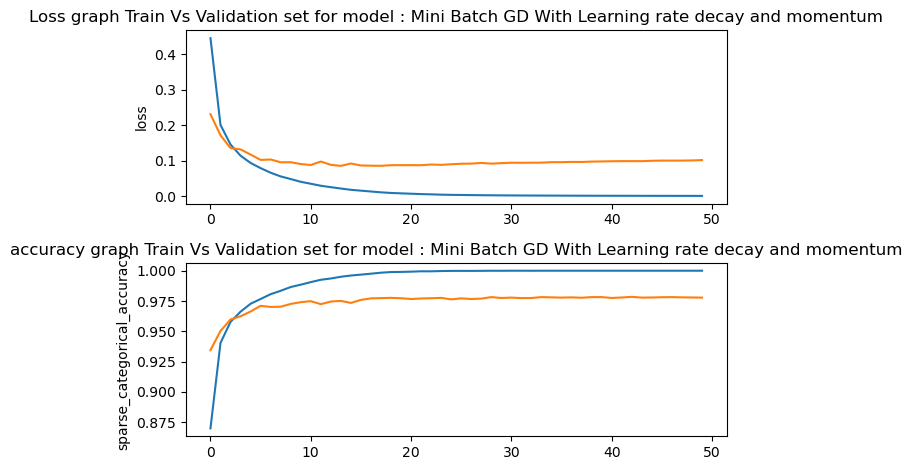

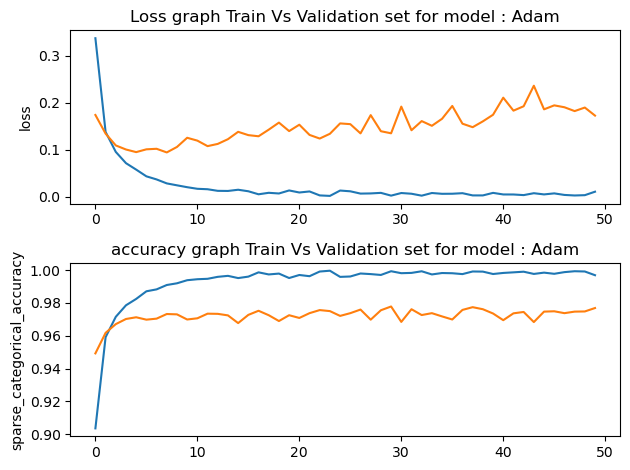

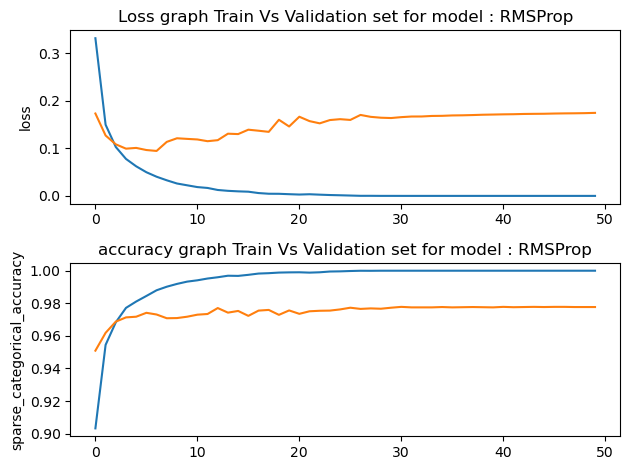

In [63]:
plot_overfitting_graphs(histories_df)

While **Adam** and **RMSProp** exhibit faster convergence, they can sometimes lead to **overfitting**, especially when trained for too long with a large learning rate. This is because their adaptive nature allows **rapid learning** but may cause instability if not carefully managed. On the other hand, **Stochastic Gradient Descent (SGD)** tends to perform worse on the validation set due to the inherent noise introduced during training. **The higher the batch size**, **the noisier the updates**, which can lead to fluctuating gradients and slower overall convergence. <br> Consequently, selecting an optimization strategy requires a trade-off between convergence speed and generalization performance.



# 3 PART TOW : OPTIMIZING HYPERPARAMETERS

In [64]:
figures = {}

In [65]:
histories_df = pd.read_csv(os.path.join("output-parttwo","histories_df.csv"))
evaluation_df = pd.read_csv(os.path.join("output-parttwo","evaluation.csv"))
durations_df = pd.read_csv(os.path.join("output-parttwo","durations.csv"))

## 3.1 DISCUSSING THE TRAINING TIME OF THE MODELS


In [66]:
durations_df.columns = ["model","duration"]
durations_df

,model,duration
0,Mini-Batch SGD,90.481182
1,Mini-Batch SGD + Early Stopping,87.512028
2,Mini-Batch SGD With L2 Nomralization,89.295324
3,Mini-Batch SGD With Dropout Rate = 0.2,91.535797
4,Mini-Batch SGD With Dropout Rate = 0.3,92.668308
5,Mini-Batch SGD With Dropout Rate = 0.5,92.172232
6,Mini-Batch SGD With Batch Normalization,94.826517
7,Random Search,177.411736


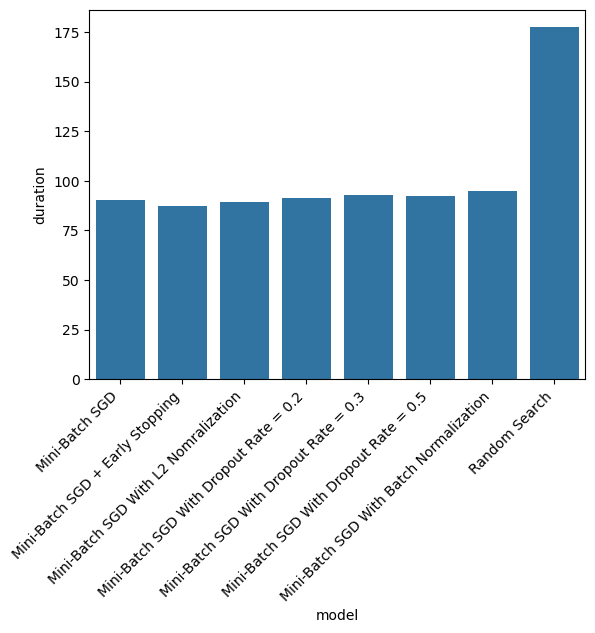

In [67]:
ax = sns.barplot(x=durations_df["model"],y=durations_df["duration"])
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')

The training time for all the models is approximately the same except for the model that uses early stopping which has a
significantly smaller training time because the training stopped at epoch 28 instead of 50,and the random search have the
highest training time among all the models because the best batch size value that was found through random search is 16
which is less than the batch size that we used to train the other models and we know that using a smaller batch size leads
to a longer training time.


## 3.2 DISCUSSING THE PERFORMANCES OF THE DIFFERENT MODELS

In [68]:
evaluation_df.index = durations_df["model"]
evaluation_df

,loss,accuracy
model,,
Mini-Batch SGD,0.088996,0.973437
Mini-Batch SGD + Early Stopping,0.094729,0.972292
Mini-Batch SGD With L2 Nomralization,0.218744,0.953333
Mini-Batch SGD With Dropout Rate = 0.2,0.084547,0.974063
Mini-Batch SGD With Dropout Rate = 0.3,0.090304,0.974375
Mini-Batch SGD With Dropout Rate = 0.5,0.090187,0.973437
Mini-Batch SGD With Batch Normalization,0.100966,0.974896
Random Search,0.119848,0.979792


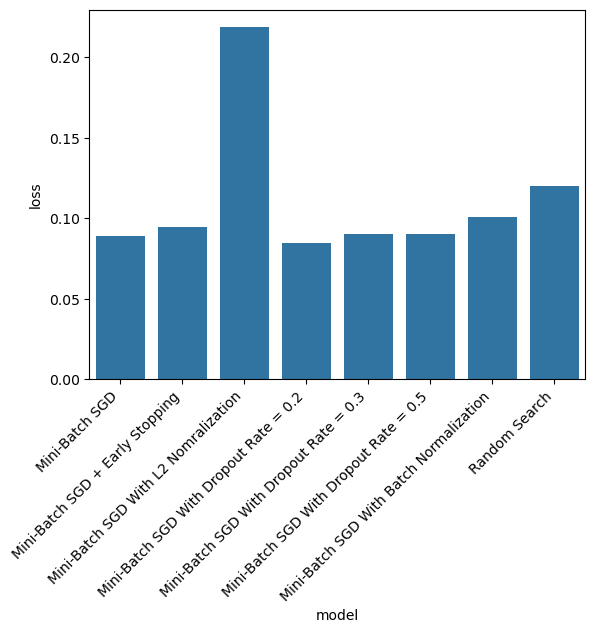

In [69]:
ax = sns.barplot(x=evaluation_df.index,y=evaluation_df["loss"])
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')

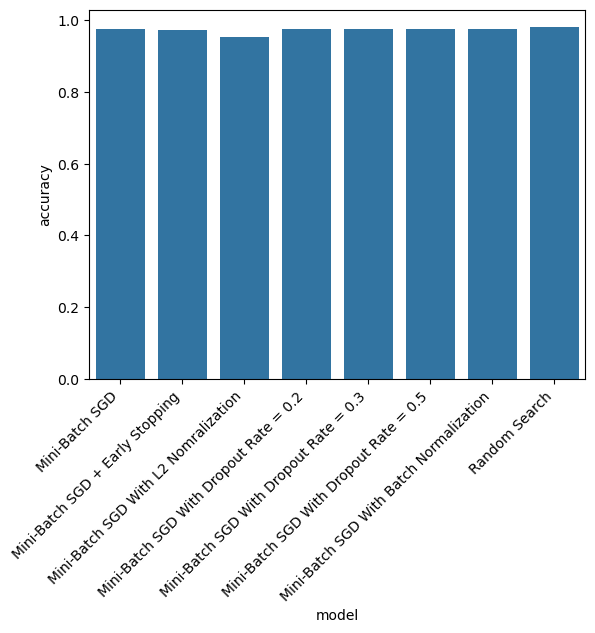

In [70]:
ax = sns.barplot(x=evaluation_df.index,y=evaluation_df["accuracy"])
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')

The comparison of different models highlights significant differences in both loss and accuracy. In the first plot, we observe that the model trained with L2 regularization exhibits the highest loss, indicating that it struggled to generalize well. On the other hand, models trained with dropout at rates of 0.2, 0.3, and 0.5 show lower loss values, suggesting that dropout effectively mitigated overfitting. The random search-based model exhibits a slightly higher loss than some of the dropout models, but it remains competitive. <br> <br>
In the second plot, accuracy remains relatively high across all models, showing that they performed well overall. However, the model trained with L2 normalization has slightly lower accuracy, aligning with its higher loss. Models trained with dropout and mini-batch SGD maintain high accuracy, indicating their effectiveness in stabilizing training. Notably, the random search model also achieves high accuracy, reinforcing the importance of hyperparameter tuning in optimizing deep neural networks

## 3.3 COMPARING THE LEARNING GRAPHS FOR THE DIFFERENT MODELS

In [71]:
histories_df.head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,model
0,0.799754,0.787474,0.380108,0.898646,Mini-Batch SGD
1,0.352073,0.899193,0.307207,0.914375,Mini-Batch SGD
2,0.294259,0.915208,0.270481,0.923750,Mini-Batch SGD
3,0.257769,0.924974,0.241106,0.933021,Mini-Batch SGD
4,0.230876,0.933542,0.223032,0.938854,Mini-Batch SGD


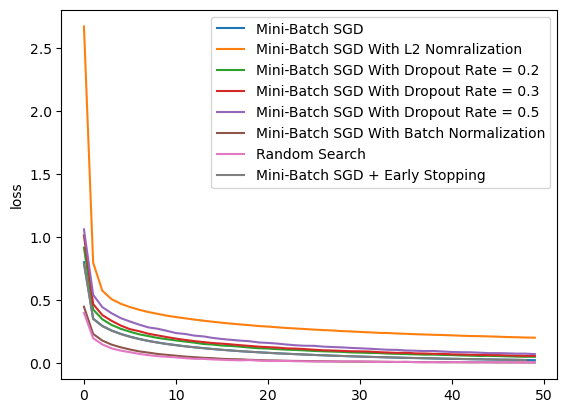

In [72]:
plot_learning_graph_in_same_axis(histories_df, "loss", "train")


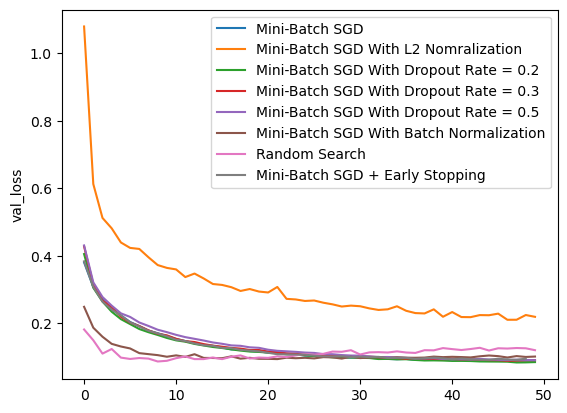

In [73]:
plot_learning_graph_in_same_axis(histories_df, "loss", "val")

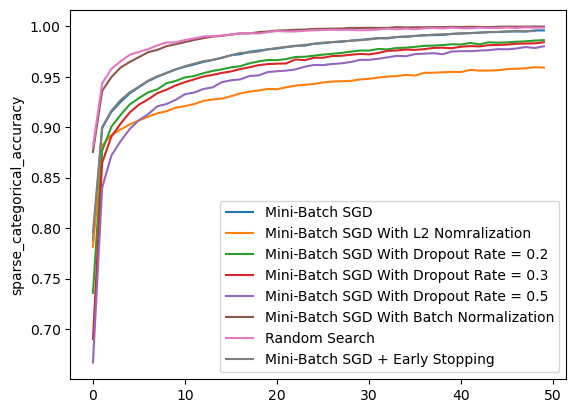

In [74]:
plot_learning_graph_in_same_axis(histories_df, "sparse_categorical_accuracy", "train")

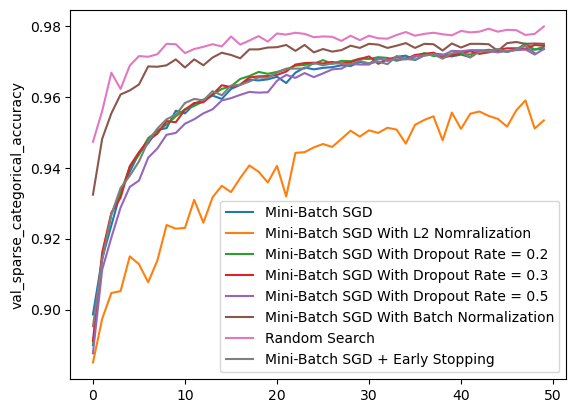

In [75]:
plot_learning_graph_in_same_axis(histories_df, "sparse_categorical_accuracy", "val")

We notice that training graphs don’t show much oscillations and the loss is deceasing steadily,with the model trained with
L2 regularization taking a few more epochs for it loss to be in comparable range with the other model,it’s also the model
with highest loss which maybe due to a large regularization parameter for this particular problem (which may cause the
model to even underfit),the model trained with batch normalization have the lowest training loss. <br> <br>
But the validation graphs don’t tell the same story,there is so much oscillations specially in the case of the mode trained
with batch normalization which maybe due to the batch being small and the network not being very deep as it is recommended to use batch normalization in the case of very deep neutral networks.

## 3.4 THE CONVERGENCE GRAPHS FOR EACH MODEL

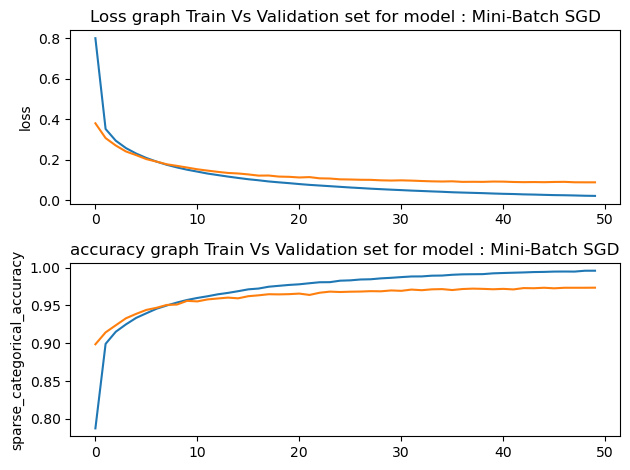

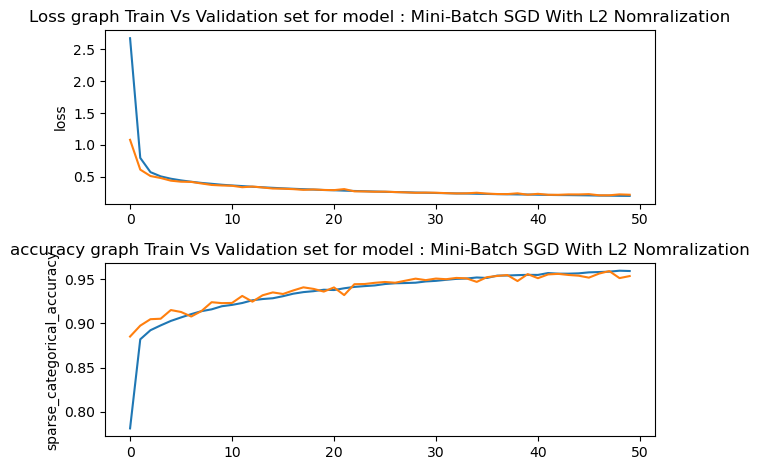

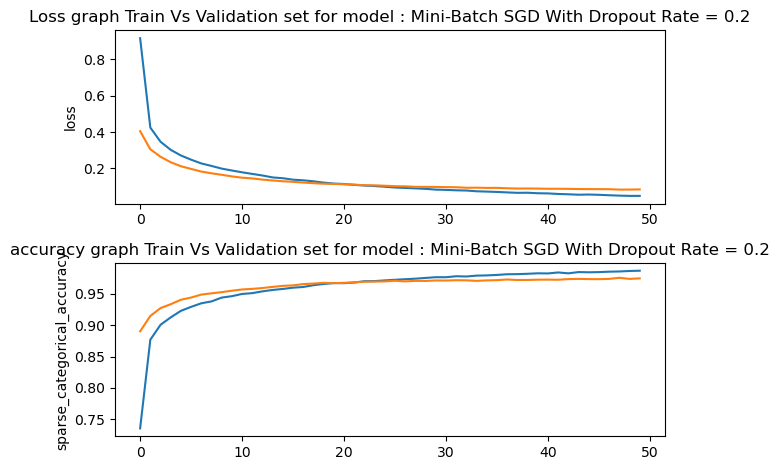

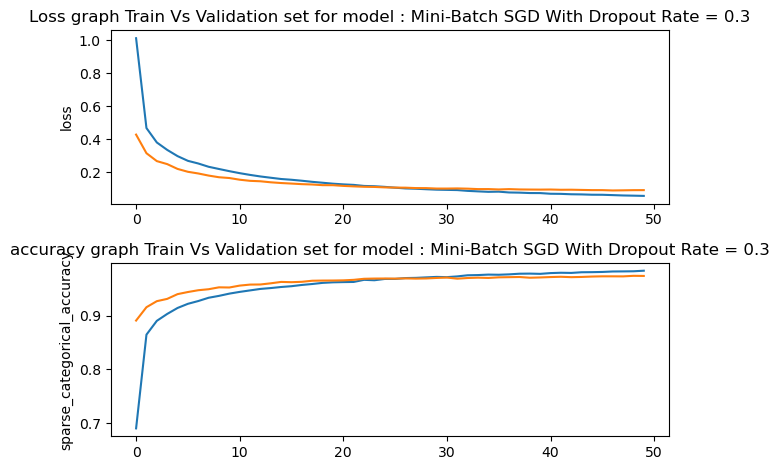

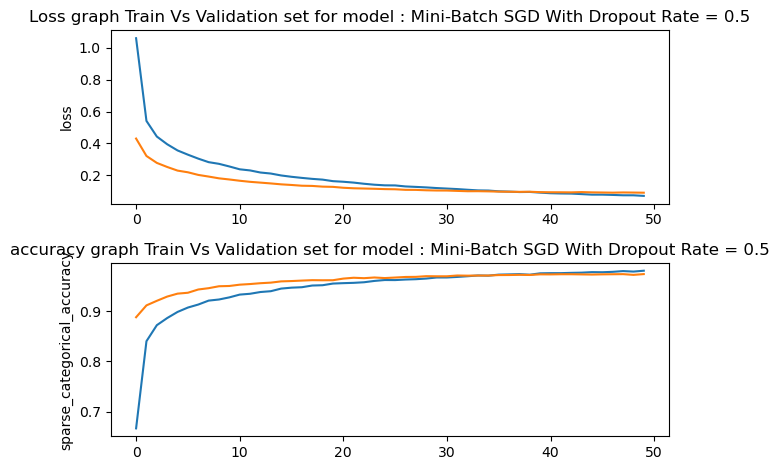

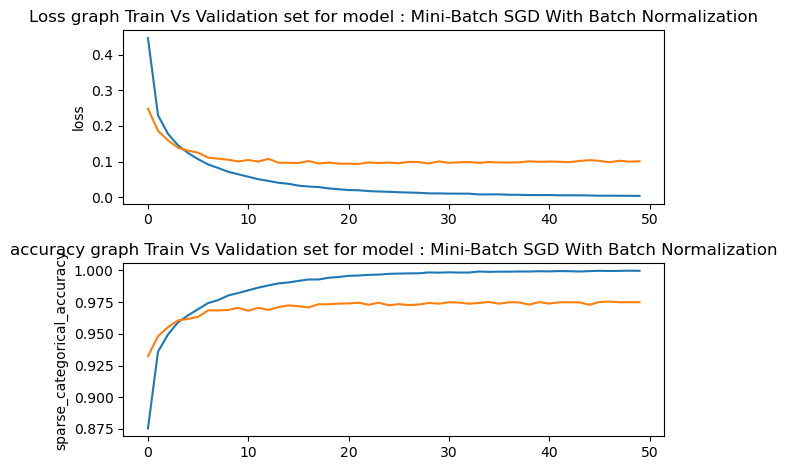

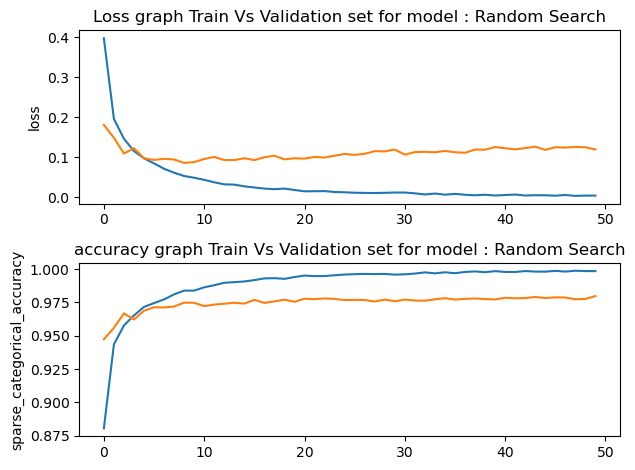

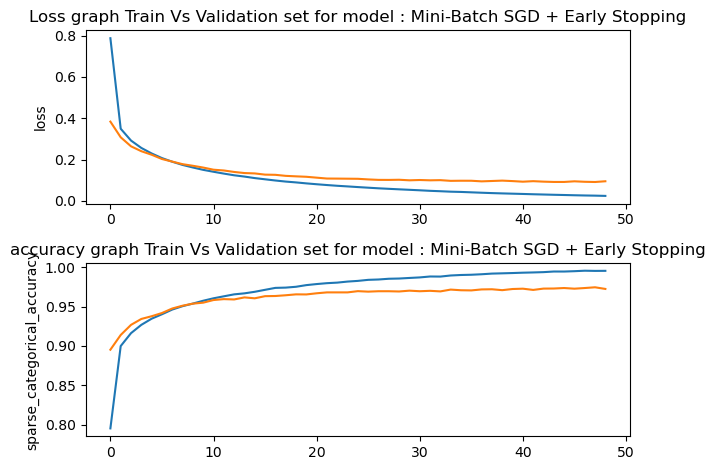

In [76]:
plot_overfitting_graphs(histories_df)

From the convergence graphs we can clearly visualize how can dropout and L2 regularization significantly reduce overfitting but also how a miss-configured batch normalization can lead to even worst results

# 4 CONCLUSION
In conclusion, our experiments provided valuable insights into training and optimizing neural networks using various optimizers and overfitting prevention techniques. We found that the choice of optimizer plays a crucial role in model performance, with Adam demonstrating faster convergence and higher final accuracy compared to SGD and RMSprop. However, while Adam improves training efficiency, careful tuning is necessary to avoid potential overfitting. <br> <br>
Additionally, incorporating regularization techniques such as dropout, batch normalization, and L2 regularization proved effective in enhancing generalization. These methods helped mitigate overfitting, leading to improved performance on unseen data. <br> <br>
Overall, our findings emphasize the importance of carefully selecting and tuning both optimization algorithms and regularization techniques. A deeper understanding of their impact on the training process enables better decision-making, ultimately leading to more robust and generalizable neural network models.